In [117]:
%load_ext autoreload
%autoreload 2
# Gestionar las rutas
import utils.paths as path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
data_dir = path.make_dir_function('data')
raw_data_dir = data_dir('raw')
csv_files = raw_data_dir.glob('*.csv')

In [120]:
csv_files_dict = {}
for csv_file in csv_files:
    csv_files_dict[f"{csv_file.name.lower().split('.')[0]}"] = csv_file

In [121]:
import pandas_profiling

In [122]:
def show_profile_report(df_name, df_cols = None, title='Pandas Profiling Report'):
    df = pd.read_csv(csv_files_dict[f'{df_name}'])
    if df_cols is None:
        df = df[df.columns]
    else:
        df = df[df_cols]
    report = df.profile_report(title=f'<b>{title} - {df_name.title()}</b>', html={'style': {'fullwidth': True}})
    return report

In [123]:
from datetime import datetime

In [124]:
# 
def change_dt_format(df, list_cols):
    for col in list_cols:
        df[col] = pd.to_datetime(df[col])#.dt.strftime('%Y-%m-%d')
    return df

<h2 align="center">Selección de variables</h2>

In [169]:
# Datasets usados para el modelo 1
df_admissions = pd.read_csv(csv_files_dict['admissions'])
df_patients = pd.read_csv(csv_files_dict['patients'])
df_icustays = pd.read_csv(csv_files_dict['icustays'])

In [170]:
# Cambiando el tipo de dato de las fechas
df_patients = change_dt_format(df_patients, ['dob', 'dod'])
df_icustays =  change_dt_format(df_icustays, ['intime', 'outtime'])

In [171]:
df_icustays.head(1)

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325


In [173]:
# Recálculo del LOS (lenght of stay)
df_icustays['los'] = (df_icustays['outtime'] - df_icustays['intime']).dt.total_seconds() / (3600*24)

In [174]:
from dateutil.relativedelta import relativedelta

# Selección de variables de los diferentes datasets
admissions_ml = df_admissions[["subject_id", "admission_type", "insurance", "language", "religion", "marital_status", "ethnicity", "hospital_expire_flag"]]
# df_patients['age_death'] = df_patients.apply(lambda x: relativedelta(x['dod'], x['dob']).years, axis=1)
patients_ml = df_patients[['subject_id', 'gender']]

In [175]:
# sns.histplot(df_patients, x='age_death')
# plt.title("Distributions de la edad de fallecimiento del paciente")
# plt.xlabel('Edad de fallecimiento (Años)')
# plt.show()

In [176]:
# Dataframe original con variables seleccionadas para el modelado con ML
df = pd.merge(admissions_ml, patients_ml, on='subject_id', how='outer')

In [206]:
# Dataframe original con variables seleccionadas para el modelado con ML
ml_df = pd.merge(admissions_ml, patients_ml, on='subject_id', how='outer')

In [177]:
df.head(2)

,subject_id,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender
0,10006,EMERGENCY,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F
1,10011,EMERGENCY,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F


<h2 align="center">Implementación de Modelos de Clusterización K-Means</h2>

K-means es un algortimo no supervisado (clustering) que funciona agrupando obsevaciones con valores de atributos similares al medir la distancia euclidiana entre puntos.

Pasos para implementar el algortimo:

Elegir el número de clústers K.
Seleccionar k puntos aleatorios que serán los centroides de cada cluster.
Asignar cada punto del dataset al centroide más cercano, esto permitirá un número k de clusters con los puntos cercanos.
Calcular un nuevo centroide para cada cluster.
Reasignar cada punto del conjunto de datos al nuevo centroide más cercano.
Repetir desde el punto cuatro en adelante hasta conseguir las métricas que buscamos optimizar.
¿Como seleccionaremos el número óptimo de Clusters (k))?

Sabemos que el número de clusters (k) es un hiperparámetro del algoritmo K-Means. Para conseguir el número optimo a priori usaremos el Método de Codo que consiste en calcular la suma de los cuadrados intra-clusters (Within Cluster Sum of Square - WCSS), esta medida aproxima como de cerca son las distancias de los puntos a los centros del cluster asigandos:

In [179]:
df.columns

Index(['subject_id', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'hospital_expire_flag', 'gender'],
      dtype='object')

In [180]:
# show_profile_report()
# Función para agregar variables ficticias para reemplazar categóricas
def categorical_var_to_dummy(df, col_name):
    dummy = pd.get_dummies(df[col_name])
    df.drop(columns=col_name, axis=1, inplace=True)
    df = pd.concat([df, dummy], axis=1)
    return df

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            129 non-null    int64 
 1   admission_type        129 non-null    object
 2   insurance             129 non-null    object
 3   language              81 non-null     object
 4   religion              128 non-null    object
 5   marital_status        113 non-null    object
 6   ethnicity             129 non-null    object
 7   hospital_expire_flag  129 non-null    int64 
 8   gender                129 non-null    object
dtypes: int64(2), object(7)
memory usage: 10.1+ KB


In [182]:
df['ethnicity'].value_counts()

WHITE                                                       86
HISPANIC/LATINO - PUERTO RICAN                              15
UNKNOWN/NOT SPECIFIED                                       11
BLACK/AFRICAN AMERICAN                                       7
OTHER                                                        3
ASIAN                                                        2
HISPANIC OR LATINO                                           2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
UNABLE TO OBTAIN                                             1
Name: ethnicity, dtype: int64

Consideramos como una categoría única los que registros de pacientes cuyo grupo étnico sean ``'UNKNOWN/NOT SPECIFIED'``, ``'OTHER'`` y ``UNABLE TO OBTAIN`` como ``'OTHER UNK_NS UNA_OBT'``.

In [183]:
ethnicity_codes = {
    'BLACK/AFRICAN AMERICAN': 'BLACK AFRI_AMER',
    'UNKNOWN/NOT SPECIFIED': 'OTHER UNK_NS UNA_OBT',
    'WHITE': 'WHITE',
    'OTHER': 'OTHER UNK_NS UNA_OBT',
    'ASIAN': 'ASIAN',
    'HISPANIC OR LATINO': 'HISP LATIN',
    'HISPANIC/LATINO - PUERTO RICAN': 'PUERTO RICAN',
    'UNABLE TO OBTAIN': 'OTHER UNK_NS UNA_OBT',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'AMERERICAN INDIAN'
}

In [184]:
# Aplicamos la la transformacion de recategorización
df['ethnicity'] = df['ethnicity'].replace(ethnicity_codes)

In [185]:
# Reemplazo de valores completos de los idiomas
df['language'] = df['language'].str.replace('ENGL', 'ENGLISH')
df['language'] = df['language'].str.replace('SPAN', 'SPANISH')
df['language'] = df['language'].str.replace('RUSS', 'RUSSIAN')
df['language'] = df['language'].str.replace('POLI', 'POLISH')
df['language'] = df['language'].str.replace('MAND', 'MANDARIN')

In [186]:
# Reemplar los valores nulos por "Otro/OTHER"
df['language'] = df['language'].fillna('OTHER')

In [ ]:
# Conversion  de las variables categóricas a variables dummy
df = categorical_var_to_dummy(df, 'admission_type')
df = categorical_var_to_dummy(df, 'insurance')
df = categorical_var_to_dummy(df, 'language')
df = categorical_var_to_dummy(df, 'religion')
df = categorical_var_to_dummy(df, 'marital_status')
df = categorical_var_to_dummy(df, 'ethnicity')
df = categorical_var_to_dummy(df, 'gender')

In [189]:
# Convertimos a minúsculas los nombres de las columnas del dataframe
df.columns = [col.lower() for col in df.columns]

In [191]:
df.head(1)

,subject_id,hospital_expire_flag,elective,emergency,urgent,government,medicaid,medicare,private,english,...,widowed,amererican indian,asian,black afri_amer,hisp latin,other unk_ns una_obt,puerto rican,white,f,m
0,10006,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [192]:
# No consideraremos la columna subject_id
df = df.iloc[::, 1:]

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [194]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [195]:
# Escalamos los datos con StanderScaler()
std_scaler = StandardScaler()
df_std_scaled = std_scaler.fit_transform(df)

# Escalamos los datos con MinMaxScaler()
mm_scaler = MinMaxScaler()
df_mm_scaled = mm_scaler.fit_transform(df)

# Escalamos los datos con RobustScaler()
robust_scaler = RobustScaler()
df_robust_scaled = robust_scaler.fit_transform(df)

# Dimensiones de las listas escaladas. NO varian las dimensiones
df_std_scaled.shape, df_mm_scaled.shape, df_robust_scaled.shape

((129, 39), (129, 39), (129, 39))

In [196]:
scalers = {
    'standard': df_mm_scaled,
    'minmax': df_mm_scaled,
    'robust': df_robust_scaled
}

In [227]:
from itertools import cycle

def plot_wscc(list_scalers, num_k_optimized):
    
    plt.style.use('seaborn')
    sns.set_style('whitegrid')
    
    # lista_y = cycle([5690.427, 5690.427, 11.68018*1000])
    lista_y = []
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    x_max = 21
    for j in range(len(list_scalers)):

        scores = []

        for i in range(1,x_max):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(list_scalers[list(scalers.keys())[j]])
            scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano
            if i == num_k_optimized:
                lista_y.append(kmeans.inertia_)

        fig = plt.Figure(figsize = (12, 5))
        fig = px.line(
                    x=np.arange(1,x_max),
                    y=np.array(scores),
                    # color = next(color_list),
                    # color_discrete_sequence = px.colors.qualitative.G10,
                    height = 600,
                    markers=True,
                    labels={
                        'x': 'N° de Clusters',
                        'y': 'WCSS'
                    }
                    )
        color_font_line = next(color_cycle)
        fig.update_traces(line_color=color_font_line)
        # Configuración del diseño de elementos de la figura
        fig.update_layout(
            title={
                'text': f'Encontrar el número correcto de clusters con {list(scalers.keys())[j]} escaler',
                # 'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font_size': 22,
                'font_color': color_font_line}
            )
        # Anotación
        fig.add_annotation(
                text="Número óptimo de clusters",
                x=num_k_optimized,
                y=lista_y[j],
                arrowhead=1,
                showarrow=True,
            )
        fig.show()

In [248]:
plot_wscc(scalers,8)

In [249]:
# Implementación del modelo K-Means
# Aplicando el Algoritmo de K-Means
kmeans = KMeans(8)
kmeans.fit(df_robust_scaled)
labels = kmeans.labels_
# Etiquetas del clúster asociados a cada observación
labels

array([3, 4, 4, 3, 2, 3, 3, 2, 2, 3, 1, 0, 7, 4, 2, 2, 4, 3, 3, 3, 1, 1,
       3, 2, 6, 4, 4, 2, 1, 3, 2, 2, 2, 2, 6, 2, 2, 2, 4, 1, 1, 3, 1, 3,
       3, 4, 4, 4, 1, 1, 4, 0, 0, 4, 3, 4, 3, 7, 7, 1, 1, 7, 7, 1, 6, 6,
       7, 7, 7, 7, 7, 0, 7, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 7, 7, 6, 2, 1, 1, 7, 7, 1, 7, 6, 7, 7, 7, 7, 7, 0, 1, 1,
       1, 0, 1, 1, 6, 7, 7, 7, 1, 1, 0, 7, 6, 6, 6, 1, 7, 6, 6])

In [250]:
# Dimension del dataframe formado por los baricentros de los clusters
kmeans.cluster_centers_.shape

(8, 39)

Generación de un dataframe con los centroides de los **7 clusters** y recordemos que estos resultados están escalados con ``RobustScaler()``. Así mismo, realizaremos una tranformación inversa para poder volver a los valores originales del dataset a través del patrón del algoritmo del metodo de escalado para tener un mejor entendimiento de lo registros que ocupan los centroides en la escala original.

In [251]:
# Dataframe de centroides de los dosclusters con datos escalados usando el método Standard Scaler
cc_robust = pd.DataFrame(data=kmeans.cluster_centers_, columns=[df.columns])
# Dataframe de centroides de los dosclusters con datos transformados al original del escalado con Standard Scaler
cc_robust_inv_transf = pd.DataFrame(data=std_scaler.inverse_transform(cc_robust), columns=[df.columns])

In [252]:
cc_robust.head()

,hospital_expire_flag,elective,emergency,urgent,government,medicaid,medicare,private,english,mandarin,...,widowed,amererican indian,asian,black afri_amer,hisp latin,other unk_ns una_obt,puerto rican,white,f,m
0,0.571429,0.000000,1.387779e-17,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.428571e-01,0.000000,...,5.714286e-01,0.000000,0.000000,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,-5.551115e-17,8.571429e-01,-8.571429e-01
1,0.346154,0.038462,-3.846154e-02,-1.214306e-17,0.038462,7.692308e-02,-0.230769,0.115385,7.307692e-01,0.038462,...,-8.326673e-17,0.076923,0.038462,3.846154e-02,-1.214306e-17,-8.326673e-17,-8.326673e-17,-1.538462e-01,-3.330669e-16,3.330669e-16
2,0.400000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.387779e-17,-0.066667,0.066667,6.666667e-02,0.000000,...,2.000000e-01,0.000000,0.000000,1.333333e-01,0.000000e+00,6.666667e-02,0.000000e+00,-2.000000e-01,0.000000e+00,0.000000e+00
3,0.200000,0.066667,-1.333333e-01,6.666667e-02,0.000000,6.666667e-02,-0.133333,0.066667,5.551115e-17,0.000000,...,1.333333e-01,0.000000,0.066667,1.333333e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000e-01,1.000000e+00,-1.000000e+00
4,0.615385,0.000000,-7.692308e-02,7.692308e-02,0.000000,1.538462e-01,-0.769231,0.615385,0.000000e+00,0.000000,...,-1.387779e-17,0.000000,0.000000,0.000000e+00,0.000000e+00,9.230769e-01,-1.387779e-17,-9.230769e-01,7.692308e-01,-7.692308e-01


In [253]:
cc_robust_inv_transf

,hospital_expire_flag,elective,emergency,urgent,government,medicaid,medicare,private,english,mandarin,...,widowed,amererican indian,asian,black afri_amer,hisp latin,other unk_ns una_obt,puerto rican,white,f,m
0,0.574378,0.062016,0.922481,0.015504,0.007752,0.046512,0.759690,0.186047,0.520677,0.007752,...,0.299456,0.015504,0.015504,0.054264,0.015504,0.116279,0.116279,0.666667,0.884375,0.115625
1,0.470182,0.071292,0.912195,0.015504,0.011125,0.062711,0.661089,0.230948,0.813137,0.011125,...,0.116279,0.025007,0.020256,0.062977,0.015504,0.116279,0.116279,0.594143,0.457364,0.542636
2,0.495088,0.062016,0.922481,0.015504,0.007752,0.046512,0.731205,0.211989,0.482776,0.007752,...,0.180391,0.015504,0.015504,0.084469,0.015504,0.137650,0.116279,0.572386,0.457364,0.542636
3,0.402583,0.078094,0.886825,0.023740,0.007752,0.060551,0.702720,0.211989,0.449612,0.007752,...,0.159020,0.015504,0.023740,0.084469,0.015504,0.116279,0.116279,0.572386,0.955543,0.044457
4,0.594708,0.062016,0.901910,0.025007,0.007752,0.078910,0.431019,0.425520,0.449612,0.007752,...,0.116279,0.015504,0.015504,0.054264,0.015504,0.412180,0.116279,0.231524,0.840579,0.159421
5,0.310078,0.062016,0.922481,0.015504,0.007752,0.046512,0.759690,0.186047,0.449612,0.007752,...,0.116279,0.015504,0.015504,0.054264,0.015504,0.116279,0.436838,0.195262,0.457364,0.542636
6,0.387165,0.122311,0.855627,0.015504,0.007752,0.064061,0.368024,0.510333,0.947067,0.007752,...,0.116279,0.015504,0.015504,0.054264,0.015504,0.116279,0.116279,0.666667,0.540394,0.459606
7,0.452393,0.089844,0.891625,0.015504,0.007752,0.046512,0.743256,0.201014,0.927934,0.007752,...,0.190254,0.015504,0.015504,0.071689,0.025007,0.140937,0.116279,0.557881,0.955543,0.044457


Ahora bien, si nos llegara un nuevo cpaciente y queremos catalogar o clasificar dentro de los **6 grupos/clusters** que hemos modelado podemos hacerlo directamente usando el método ``.fit_predict()`` del algoritmo de K-Means.

In [254]:
y_kmeans = kmeans.fit_predict(df_robust_scaled)
y_kmeans

array([6, 4, 4, 6, 0, 6, 6, 0, 0, 6, 0, 6, 7, 4, 0, 0, 4, 6, 6, 6, 0, 0,
       6, 0, 5, 4, 4, 0, 1, 6, 0, 0, 0, 0, 5, 0, 0, 0, 4, 0, 0, 6, 0, 6,
       6, 4, 4, 4, 1, 1, 4, 7, 7, 4, 6, 4, 6, 2, 2, 1, 1, 7, 7, 1, 5, 5,
       7, 7, 7, 7, 2, 7, 7, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 7, 7, 5, 0, 1, 1, 7, 7, 1, 2, 5, 2, 7, 2, 2, 7, 1, 1, 1,
       1, 7, 1, 1, 5, 2, 7, 7, 1, 1, 7, 7, 5, 5, 5, 1, 2, 5, 2])

Agregamos una etiqueta (qúe cluster) correspondiente a cada punto de los datos.

In [255]:
df.head(1)

,hospital_expire_flag,elective,emergency,urgent,government,medicaid,medicare,private,english,mandarin,...,widowed,amererican indian,asian,black afri_amer,hisp latin,other unk_ns una_obt,puerto rican,white,f,m
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [256]:
sale_df_std_cluster = pd.concat([ml_df, pd.DataFrame({'cluster':labels})], axis=1)
sale_df_std_cluster.head()

,subject_id,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,cluster
0,10006,EMERGENCY,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,3
1,10011,EMERGENCY,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,4
2,10013,EMERGENCY,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,1,F,4
3,10017,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,F,3
4,10019,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,1,M,2


In [257]:
ml_df

,subject_id,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender
0,10006,EMERGENCY,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F
1,10011,EMERGENCY,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F
2,10013,EMERGENCY,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,1,F
3,10017,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,F
4,10019,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,1,M
...,...,...,...,...,...,...,...,...,...
124,44083,EMERGENCY,Private,ENGL,CATHOLIC,SINGLE,WHITE,0,M
125,44154,EMERGENCY,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,1,M
126,44212,EMERGENCY,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,0,F
127,44222,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M


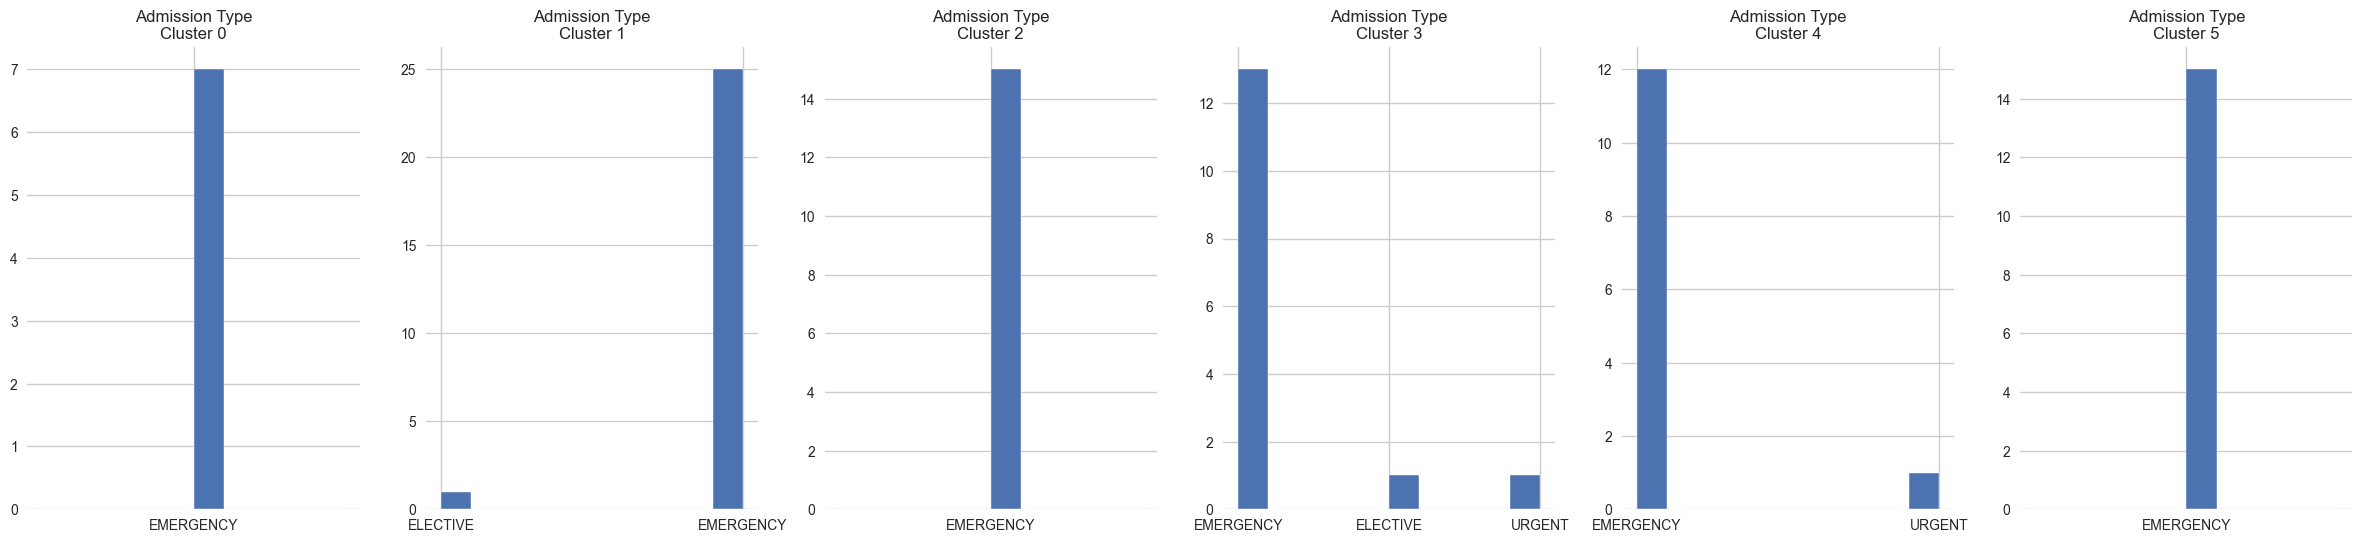

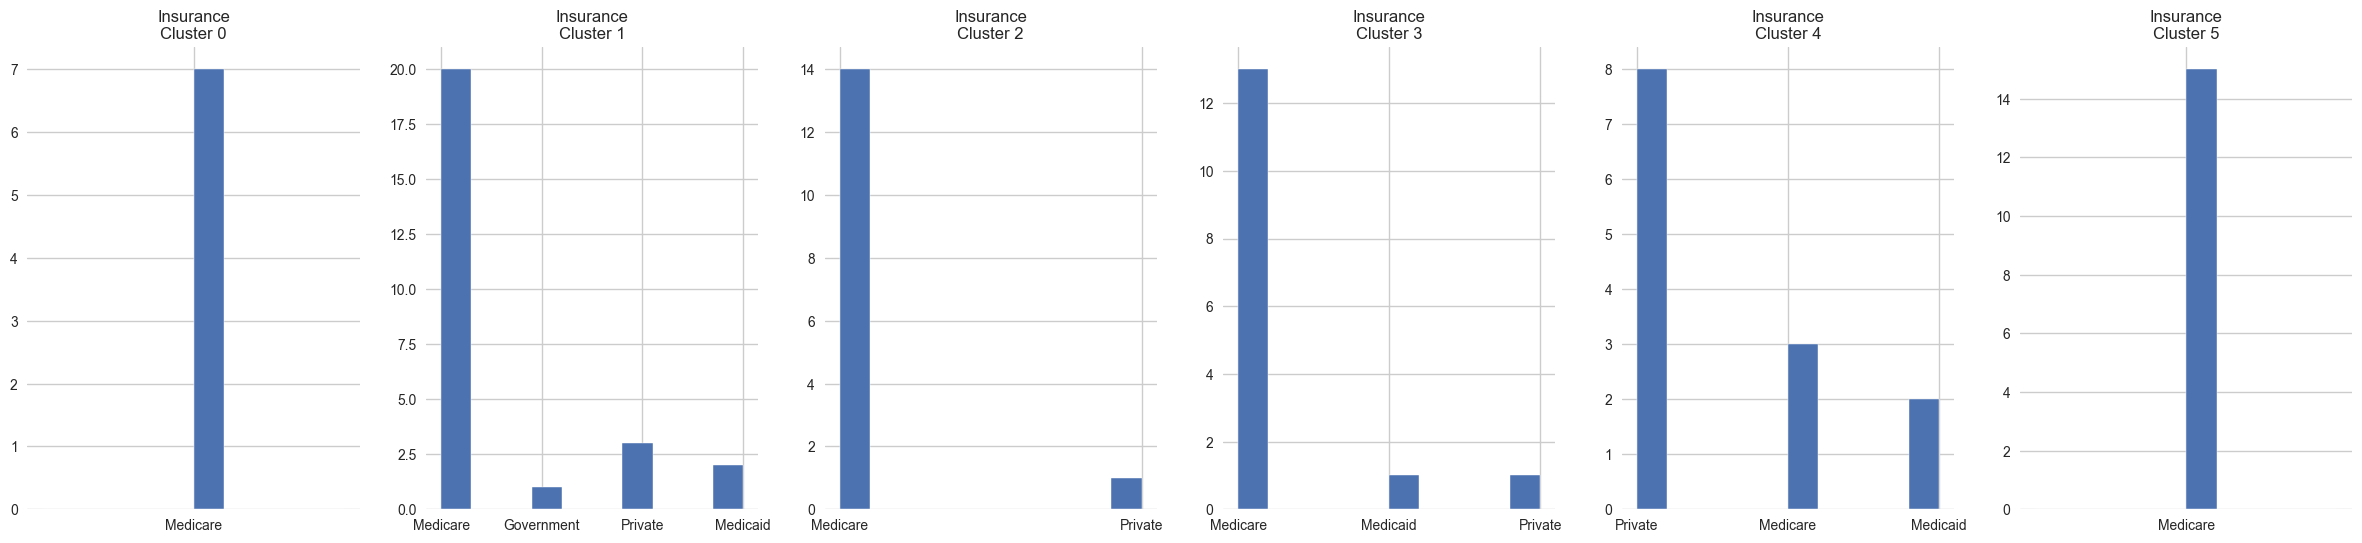

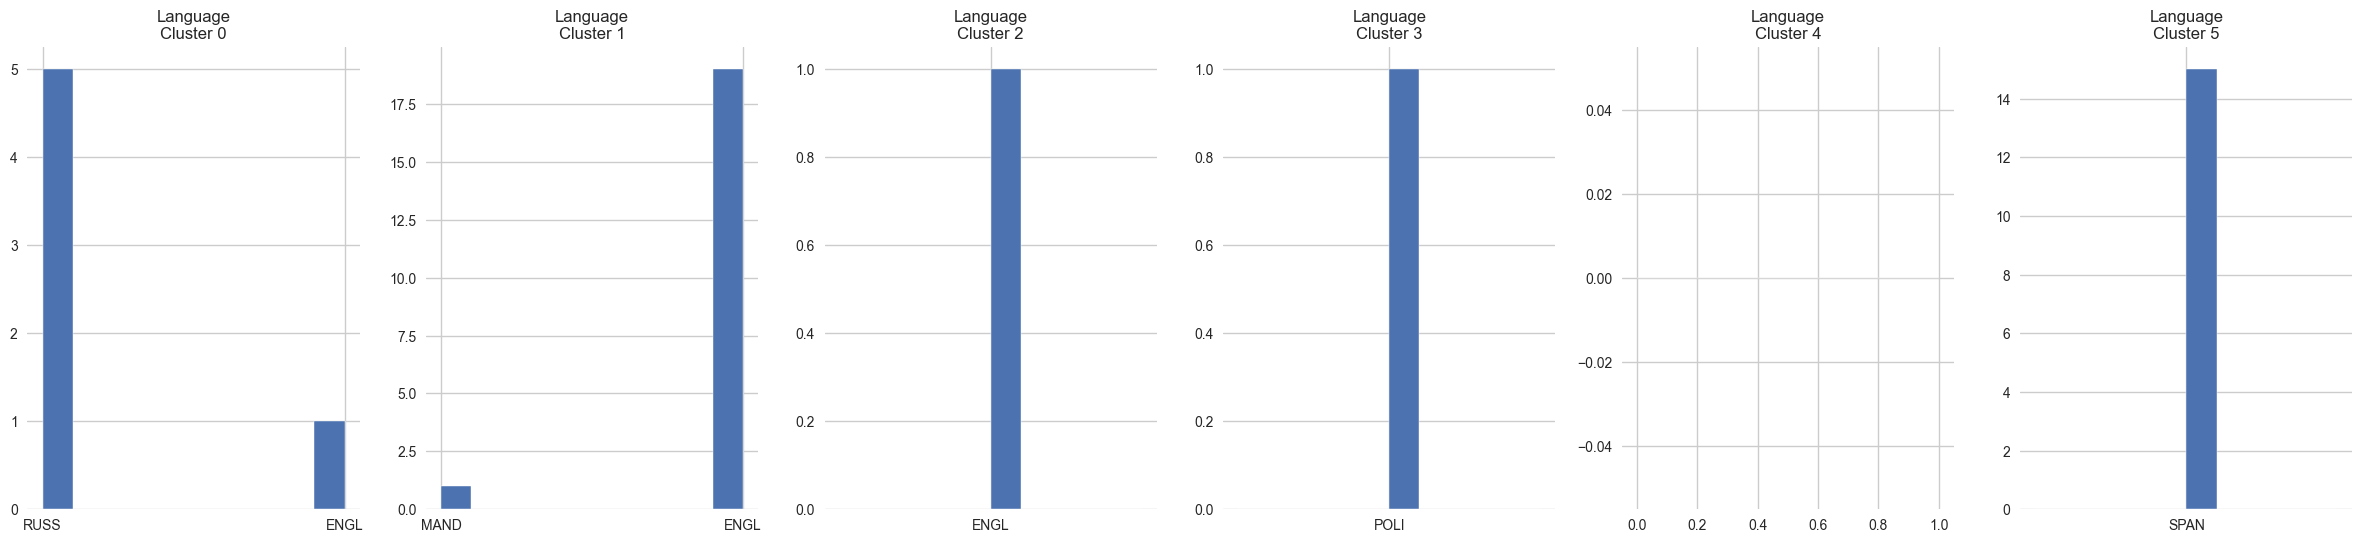

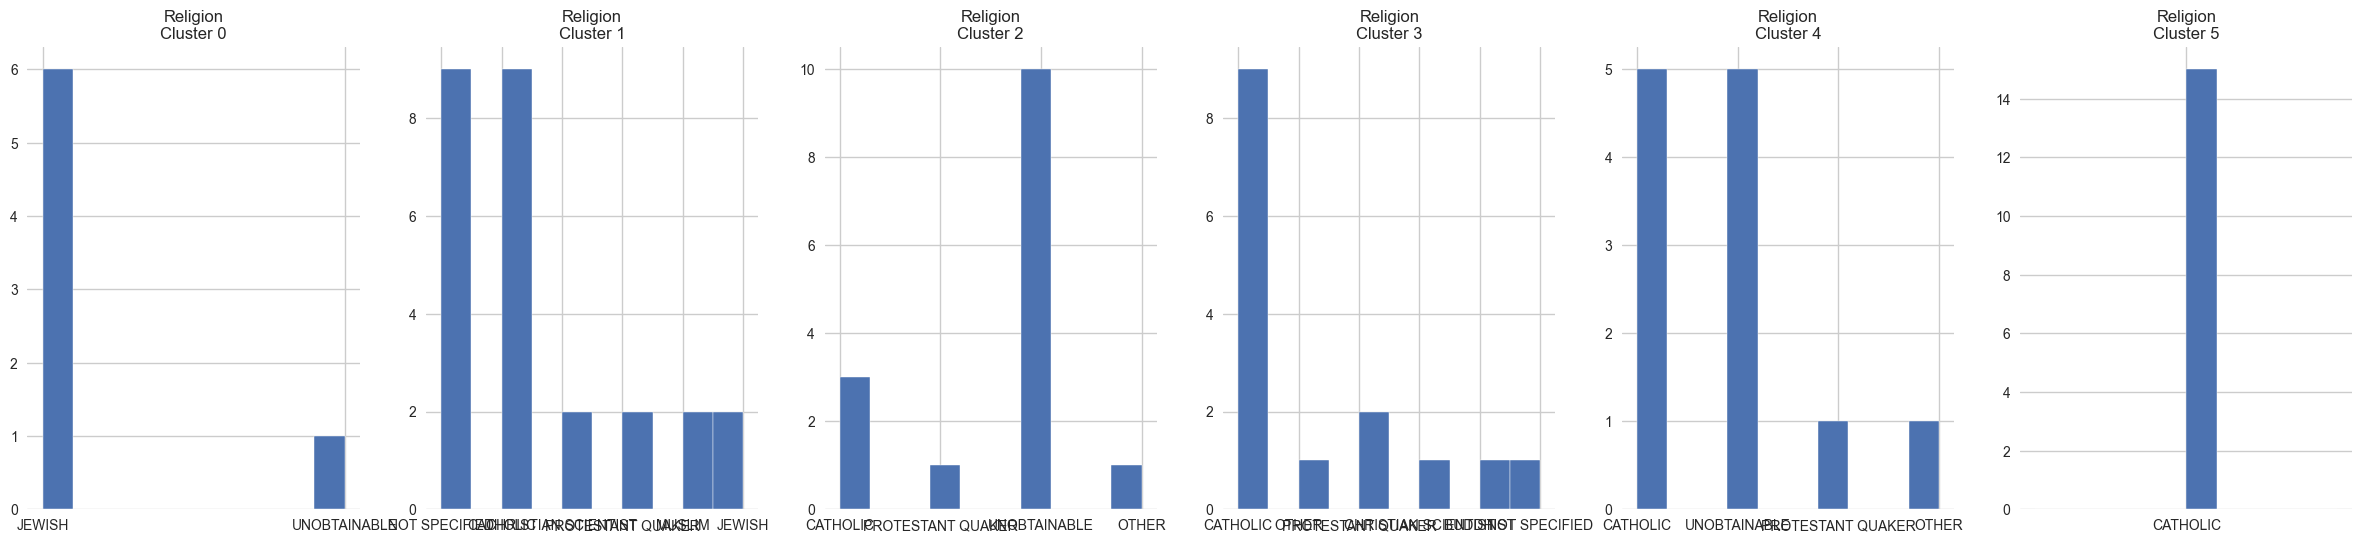

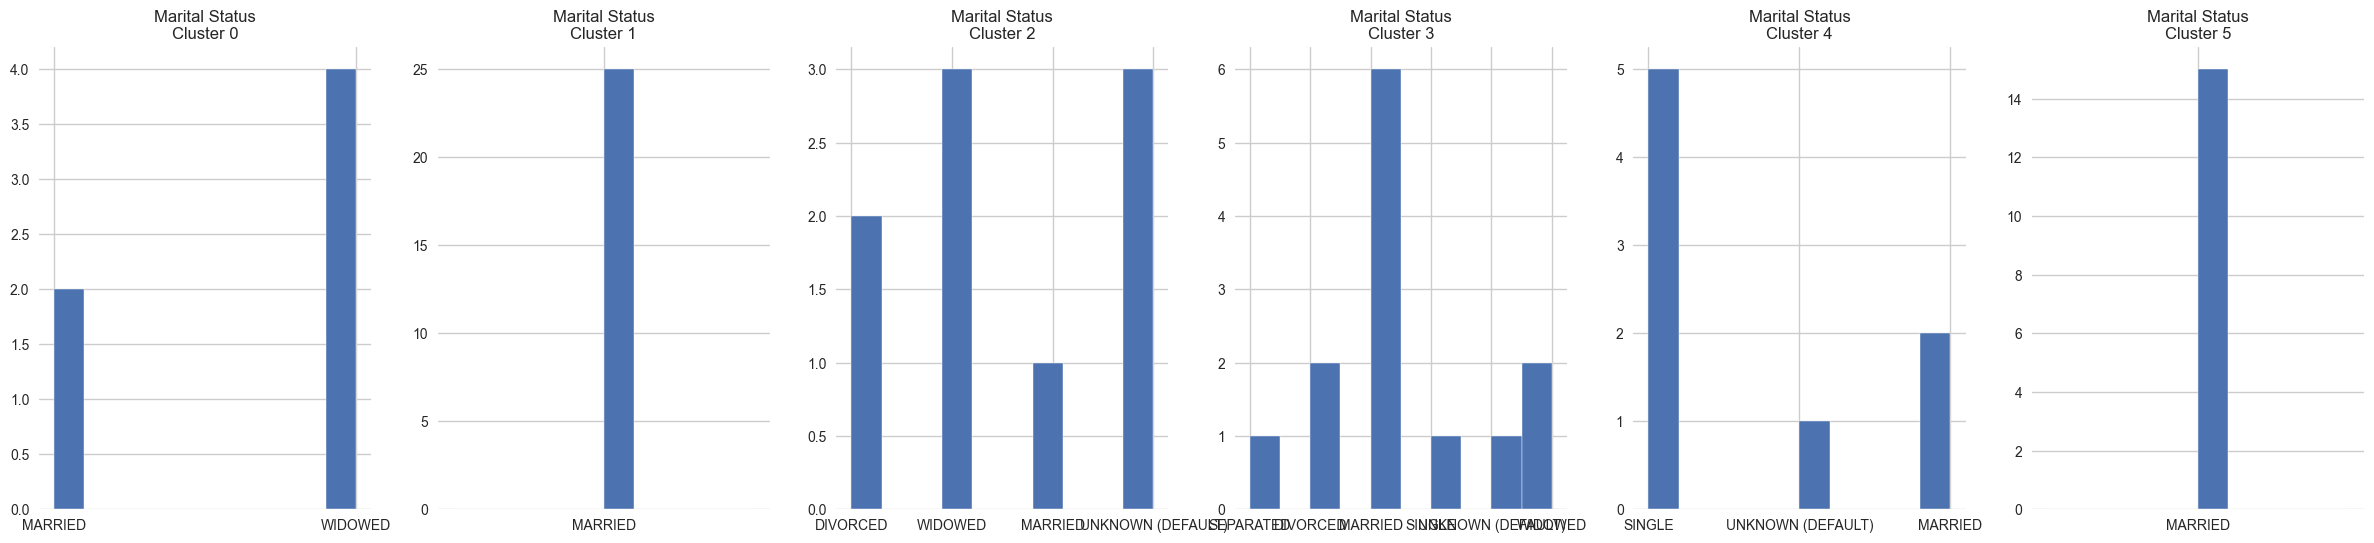

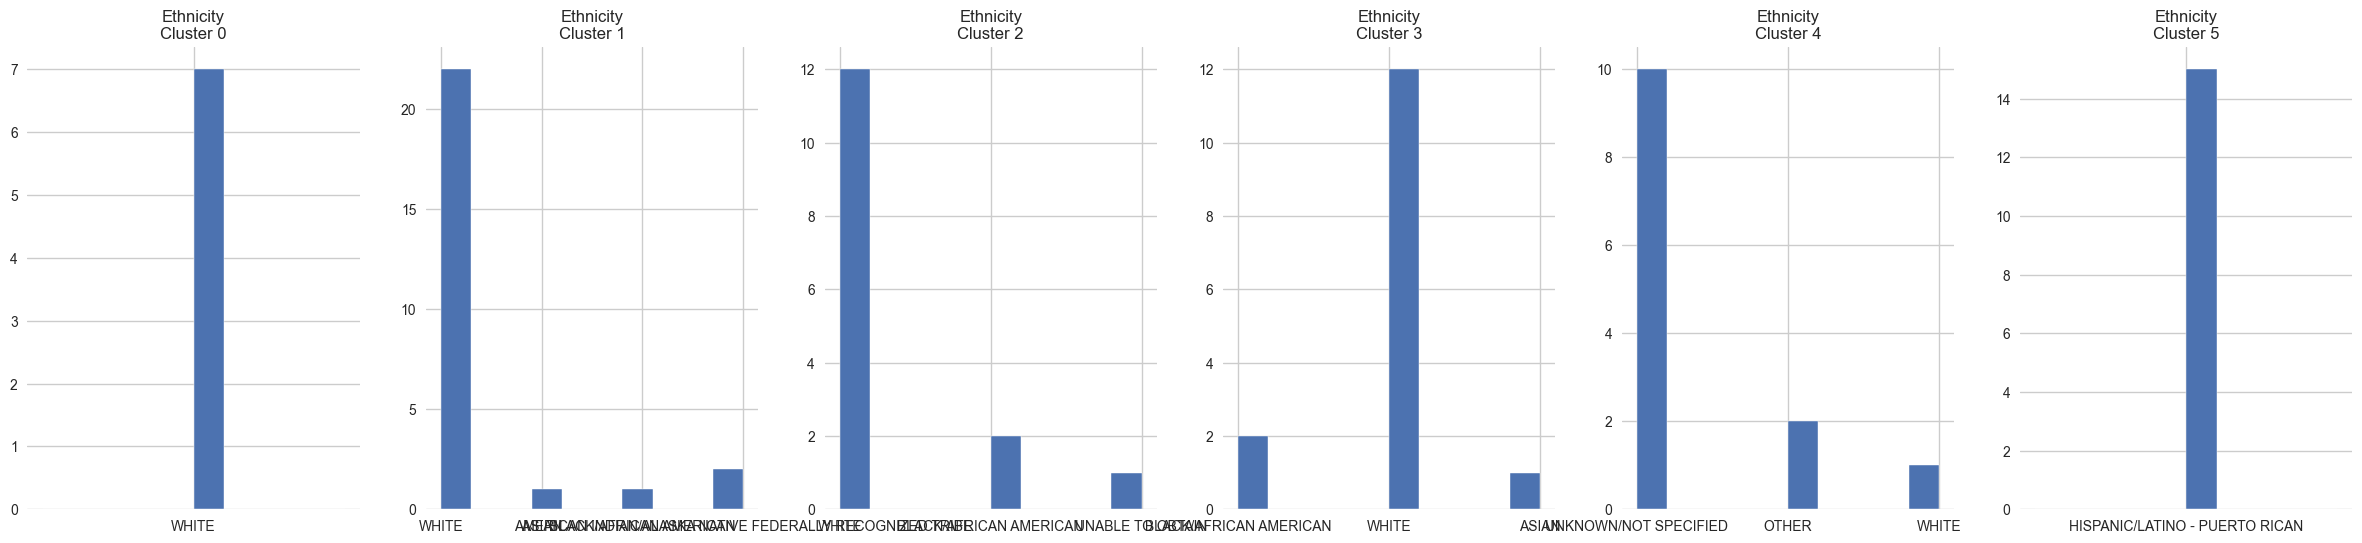

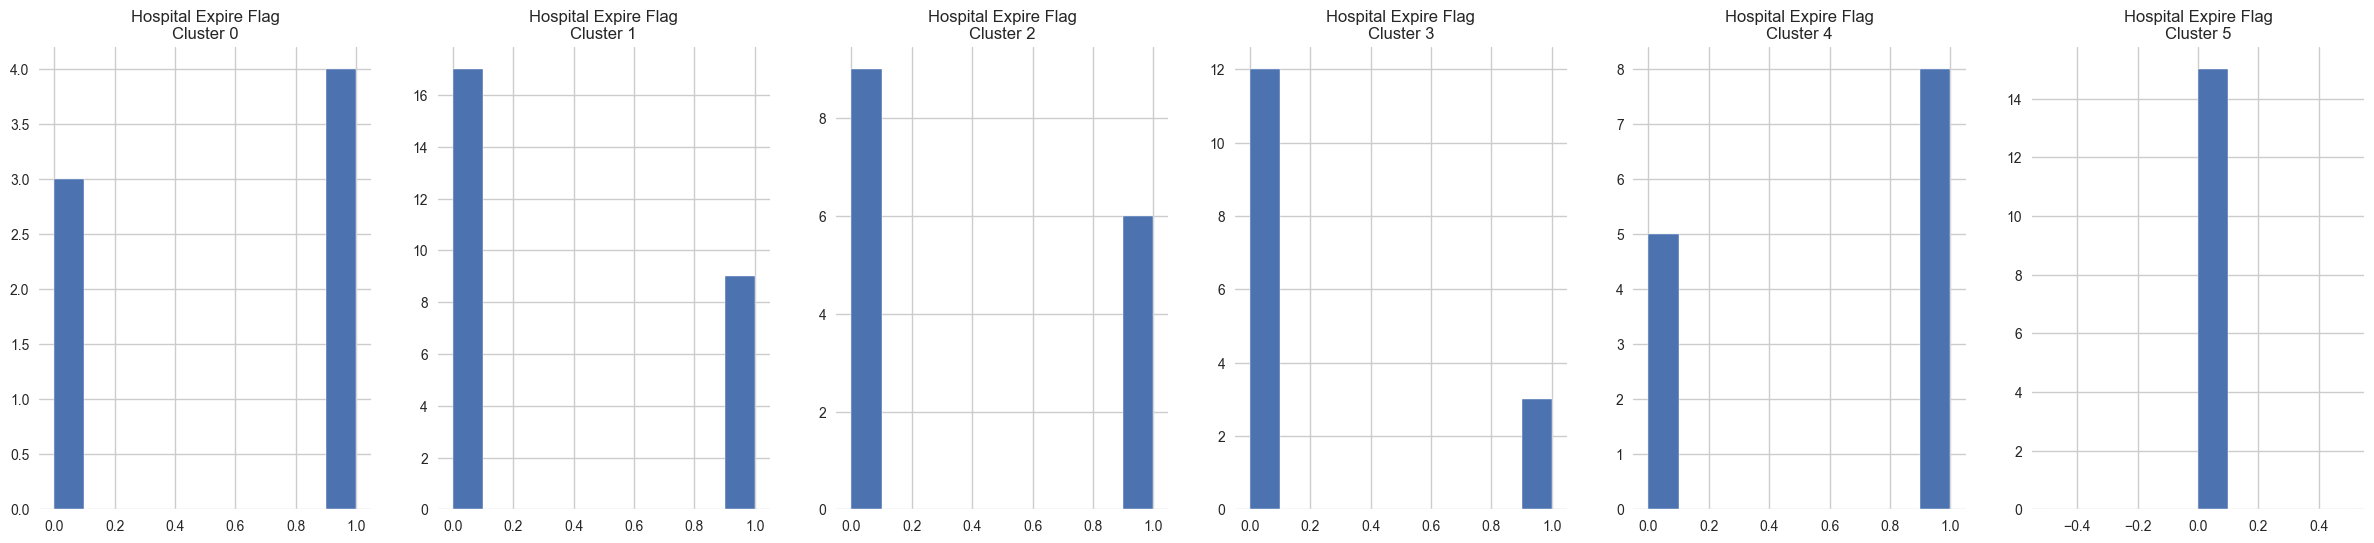

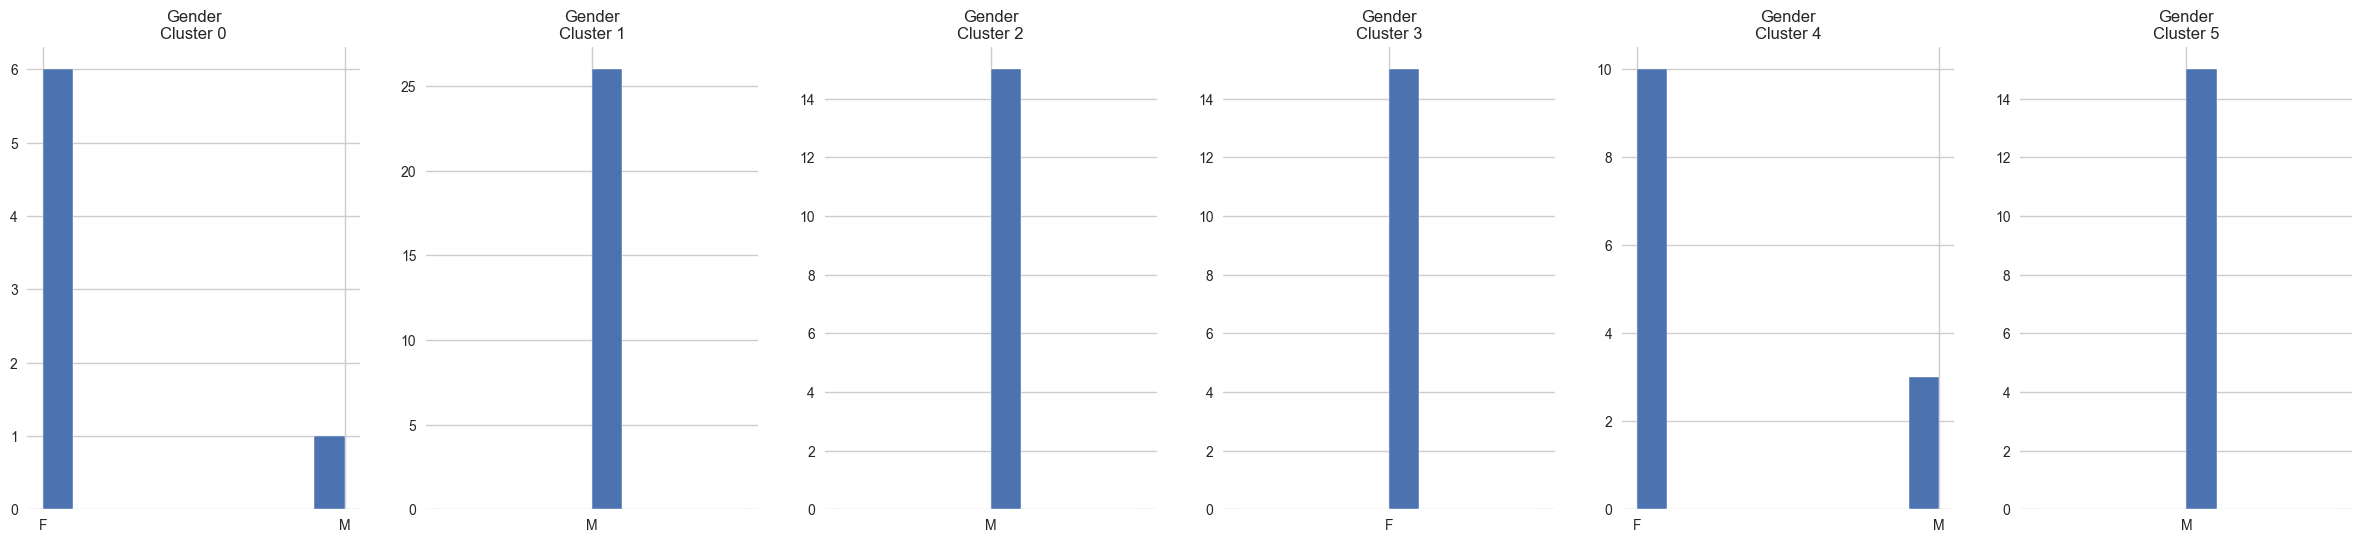

In [258]:
num_cluster = 6
for i in ml_df.columns[1:]:
    plt.figure(figsize=(30,6))
    for j in range(num_cluster):
        plt.subplot(1,num_cluster,j+1)
        cluster = sale_df_std_cluster[sale_df_std_cluster['cluster']==j]
        cluster[i].hist()
        plt.title(f"{i.replace('_', ' ').title()}\nCluster {j}")
plt.show()

## **Aplicacion de Analisis de Componentes Principales (PCA)**

In [259]:
# Reducción de los datos originales a 3 dimensiones usando PCA para visualizar los clusters
pca_3d = PCA(n_components=3)
principal_component_3d = pca_3d.fit_transform(df_robust_scaled)
principal_component_3d

array([[-4.40466231e-01,  9.45565177e-01, -3.80276039e-01],
       [-9.94116498e-01,  1.01125039e+00,  1.23376441e+00],
       [-6.95518589e-01,  1.22595654e+00, -1.66359165e-01],
       [-6.17135934e-01,  5.62408382e-01, -3.84745701e-01],
       [ 1.75359083e-01,  6.78773114e-01,  1.74385537e-01],
       [-8.38894349e-01,  5.41461435e-01, -4.77459817e-01],
       [-2.26137828e-01,  3.10808299e-01, -5.16036059e-01],
       [ 6.36725616e-02,  4.75660510e-01, -4.26884483e-02],
       [ 2.72451321e-01,  4.94425466e-01,  3.57675397e-02],
       [-1.67359963e-02, -9.42925853e-02, -7.00501989e-01],
       [ 4.44795603e-01,  6.95964731e-02, -8.11074352e-02],
       [-6.26596962e-01,  4.98822637e-01, -7.95484042e-01],
       [-6.20069140e-01, -6.34722243e-01, -5.70146464e-01],
       [-8.69530835e-01,  1.25197073e+00, -2.69146141e-01],
       [ 3.95792490e-02,  6.85336386e-01,  1.05808563e-01],
       [ 3.83818980e-01,  5.14279261e-01,  1.81491135e-01],
       [-8.89764538e-01,  1.31388306e+00

In [260]:
# Convertimos en un dataframe
pca_df_3d = pd.DataFrame(data=principal_component_3d, columns=['pca1','pca2','pca3'])
pca_df_3d.head(3)

,pca1,pca2,pca3
0,-0.440466,0.945565,-0.380276
1,-0.994116,1.011250,1.233764
2,-0.695519,1.225957,-0.166359


Ahora concatenemos el dataframe pca_df con el array de labels (prediccion del clustering) transformado a un dataframe cuyo nombre de la columna será cluster.

In [261]:
pca_df_3d = pd.concat([pca_df_3d,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df_3d.head(2)

,pca1,pca2,pca3,cluster
0,-0.440466,0.945565,-0.380276,3
1,-0.994116,1.011250,1.233764,4


Graficamos la disperción por cada uno de los clusters.

In [262]:
fig = px.scatter_3d(pca_df_3d, x='pca1',y='pca2',z='pca3',color='cluster',symbol='cluster',size_max=18,opacity=0.7)
fig.update_layout(
    margin=dict(l=0,r=0,b=0,t=0),
    title={
                'text': 'Gráfica de los clusters usando PCA-3D',
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font_size': 22
                }
            )

## **Coeficiente de la Silhueta**

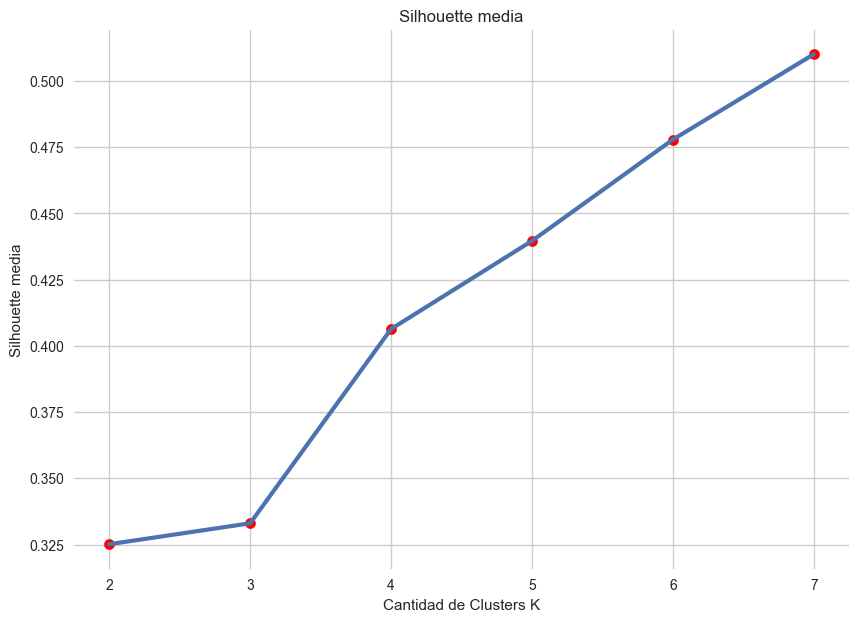

In [263]:
# Preparamos una lista donde vamos a ir agregando los valores medios de silhouette 
# Aca ponen el Dataset con el que quieren trabajar
x_robust_3d = principal_component_3d
lista_sil = []
K = np.arange(2,8)
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(x_robust_3d)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(x_robust_3d, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media')

plt.show()

In [267]:
df_robust_scaled.shape

(129, 39)

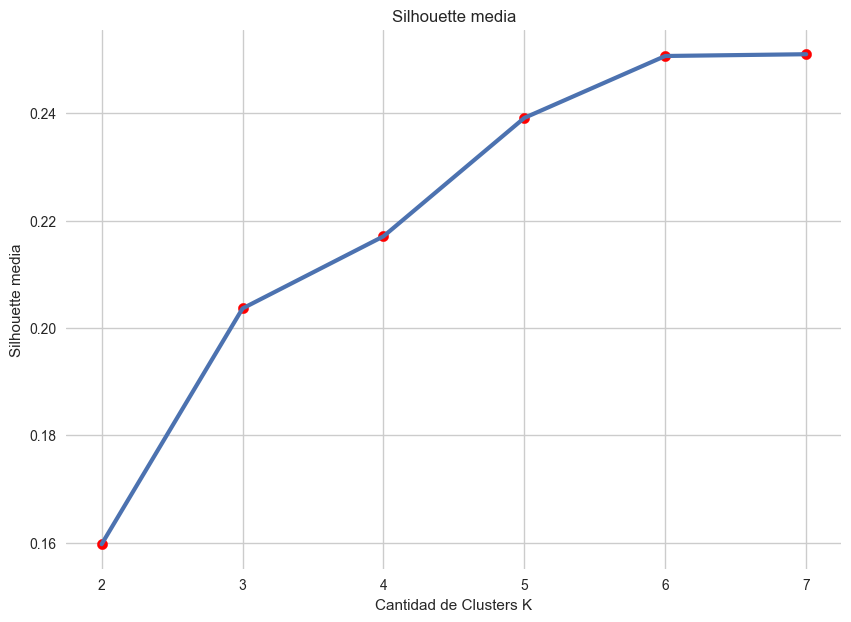

In [268]:
# Preparamos una lista donde vamos a ir agregando los valores medios de silhouette 
# Aca ponen el Dataset con el que quieren trabajar
x_robust_3d = df_robust_scaled
lista_sil = []
K = np.arange(2,8)
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(x_robust_3d)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(x_robust_3d, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media')

plt.show()

#### **Visualización de los valores de Silhueta para 2 componentes principales que fueron escalado con RobustScaler()**

In [269]:
# Visualización de los valores de Silhueta para 3 componentes principales que fueron escalado con RobustScaler()
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

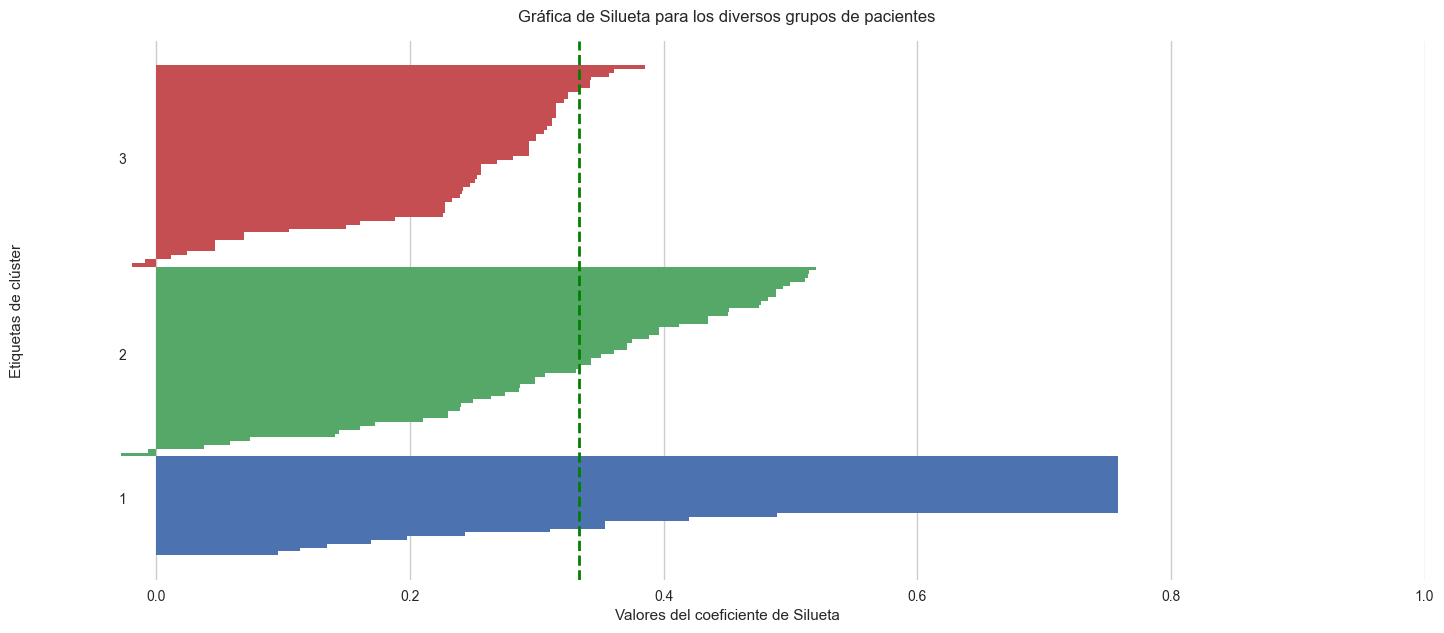

In [272]:
# Aca ponen el Dataset con el que quieren trabajar
x_robust_3d = principal_component_3d
# x_robust_3d = df_robust_scaled
# Definición de la lista de ks para los cuales quieren hacer un gráfico
lista_k = [3]
for i, k in enumerate(lista_k):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # Algoritmo KMeans
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(x_robust_3d)
    centroids = km.cluster_centers_

    # Uso de silhouette samples
    silhouette_vals = silhouette_samples(x_robust_3d, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Calculo de promedio de silhouette
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Valores del coeficiente de Silueta')
    ax1.set_ylabel('Etiquetas de clúster')
    ax1.set_title('Gráfica de Silueta para los diversos grupos de pacientes', y=1.02)

In [ ]:
# Eportar el modelo en archivo pickle
import joblib
